In [1]:
import torch
import numpy as np
import yfinance as yf
import pandas as pd
pd.options.mode.chained_assignment = None

import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [2]:
class Gen():
    def __init__(self):
        pass

    def SMA(self, data, windows):
        res = data.rolling(window = windows).mean()
        return res

    def EMA(self, data, windows):
        res = data.ewm(span = windows).mean()
        return res

    def MACD(self, data, long, short, windows):
        short_ = data.ewm(span = short).mean()
        long_ = data.ewm(span = long).mean()
        macd_ = short_ - long_
        res = macd_.ewm(span = windows).mean()
        return res

    def RSI(self, data, windows):
        delta = data.diff(1)
        up = delta.copy()
        down = delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0
        avg_up = up.rolling(window = windows).mean()
        avg_down = down.rolling(window = windows).mean()
        rs = avg_up/ avg_down
        rsi = 100. -(100./ (1. + rs))
        return rsi

    def atr(self, data_high, data_low, windows):
        range_ = data_high - data_low
        res = range_.rolling(window = windows).mean()
        return res

    def bollinger_band(self, data, windows):
        sma = data.rolling(window = windows).mean()
        std = data.rolling(window = windows).std()
        upper = sma + 2 * std
        lower = sma - 2 * std
        return upper, lower

    def rsv(self, data, windows):
        min_ = data.rolling(window = windows).min()
        max_ = data.rolling(window = windows).max()
        res = (data - min_)/ (max_ - min_) * 100
        return res

In [3]:
class StockData:
    def __init__(self, stock):
        self._stock = stock
        self._data = 0
        self._min_max = MinMaxScaler(feature_range=(0, 1))
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
    
    def load_data(self, start_date, end_date):
        self._data = yf.download(self._stock, start=start_date, end=end_date)
        self._data.reset_index(inplace=True)
        self._data['Date'] = pd.to_datetime(self._data['Date'])
        self._data = self._data[["Date", "Close", "Open", "High", "Low", "Volume", "Adj Close"]]
    
    def draw_data(self):
        cols = list(self._data)[1:]
        date = list(self._data)[0]
        plt.figure(figsize=(20, 14))
        for i, col in enumerate(cols):
            plt.subplot(len(cols), 1, (i+1))
            plt.plot(self._data[date], self._data[col])
            plt.title(col, y=0.5, loc='right')
        plt.show()
    
    def feature_extraction(self, Generator):
        data = self._data
        data['pct_change'] = (data['Close'] - data['Close'].shift(1))/ data['Close'].shift(1)
        data['log_change'] = np.log(data['Close']/ data['Close'].shift(1))
        # Add a new columns for the 7, 14 and 21 day exponential moving average (EMA) of the 'Close' price
        data['7ma'] = Generator.EMA(data['Close'], 7)
        data['14ma'] = Generator.EMA(data['Close'], 14)
        data['21ma'] = Generator.EMA(data['Close'], 21)

        # Add a new columns for the 7, 14 and 21 day Moving Average Convergence Divergence (MACD) of the 'Close' price
        data['7macd'] = Generator.MACD(data['Close'], 3, 11, 7)
        data['14macd'] = Generator.MACD(data['Close'], 7, 21, 14)

        # Add a new columns for the 7, 14 and 21 day Relative Strength Index (RSI) of the 'Close' price
        data['7rsi'] = Generator.RSI(data['Close'], 7)
        data['14rsi'] = Generator.RSI(data['Close'], 14)
        data['21rsi'] = Generator.RSI(data['Close'], 21)

        # Add a new columns for Average True Range (ATR) based on the 'High' and 'Low' prices
        data['7atr'] = Generator.atr(data['High'], data['Low'], 7)
        data['14atr'] = Generator.atr(data['High'], data['Low'], 14)
        data['21atr'] = Generator.atr(data['High'], data['Low'], 21)

        # Add a new columns for the upper and lower Bollinger Bands based on the 'Close' price and a window of 7, 14 and 21 days
        data['7upper'], data['7lower'] = Generator.bollinger_band(data['Close'], 7)
        data['14upper'], data['14lower'] = Generator.bollinger_band(data['Close'], 14)
        data['21upper'], data['21lower'] = Generator.bollinger_band(data['Close'], 21)

        # Add a new columns for the 7, 14 and 21 day Relative Strength Value (RSV) based on the 'Close' price
        data['7rsv'] = Generator.rsv(data['Close'], 7)
        data['14rsv'] = Generator.rsv(data['Close'], 14)
        data['21rsv'] = Generator.rsv(data['Close'], 21)
        
        # Compute the fast Fourier transform of the 'Close' column 
        close_fft = np.fft.fft(np.asarray(data['Close'].tolist()))

        # Create a DataFrame with the Fourier transformed values, their absolute values, and angles
        fft_df = pd.DataFrame({'fft':close_fft})
        fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
        fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

        # Convert the Fourier transformed values to an array
        fft_list = np.asarray(fft_df['fft'].tolist())

        # Iterate over a list of integers representing the number of components to keep in the Fourier transform
        for num_ in [3, 6, 9, 27, 81, 100]:
            fft_list_m10= np.copy(fft_list); # Create a copy of the Fourier transformed values
            fft_list_m10[num_:-num_] = 0 # Set all but the first and last num_ values in fft_list_m10 to zero
            data[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10) # Compute the inverse Fourier transform of fft_list_m10 and store it in a new column in data_combine
        
        data['FT_3components'] = data['FT_3components'].astype('float')
        data['FT_6components'] = data['FT_6components'].astype('float')
        data['FT_9components'] = data['FT_9components'].astype('float')
        data['FT_27components'] = data['FT_27components'].astype('float')
        data['FT_81components'] = data['FT_81components'].astype('float')
        data['FT_100components'] = data['FT_100components'].astype('float')
        
        #меняем невалидные значения
        # Заменяем 0 и inf на NA, и заполняем их
        data.replace([np.inf, -np.inf, 0], np.nan, inplace=True)
        data.iloc[:, 1:] = pd.concat([data.iloc[:, 1:].ffill(), data.iloc[:, 1:].bfill()]).groupby(level=0).mean()
        self._data = data
        self._data.sort_values(by='Date', inplace=True)
        
    def important_features(self, columns):
        self._data = self._data[columns]
    def get_train_test(self):
        scaled_data = self._min_max.fit_transform(self._data.loc[:,"Close":])
        #TrainTest split
        train, test = train_test_split(scaled_data, test_size=0.2, shuffle=False)
        return train, test
        
    def prepare_for_GAN(self, test_size, time_steps, n_future=1):
#         if (n_future>1):
#             n_future+=1
        scaled_data = self._min_max.fit_transform(self._data.loc[:,"Close":])
        #TrainTest split
        train, test = train_test_split(scaled_data, test_size=test_size, shuffle=False)
        # Добавление лагов
        X_train, y_train, gan_train = [],[],[]
        for i in range(time_steps, (train.shape[0]-n_future+1)):
            X_train.append(train[i - time_steps:i, 0:train.shape[1]])
            y_train.append(train[i:i+n_future, 0])
            gan_train.append(train[i-time_steps:i+n_future, 0])
            
        X_test, y_test, gan_test = [],[],[]
        for i in range(time_steps, (test.shape[0]-n_future+1)):
            X_test.append(test[i - time_steps:i, 0:test.shape[1]])
            y_test.append(test[i:i+n_future, 0])
            gan_test.append(train[i-time_steps:i+n_future, 0])
            
        # Размерность X должна быть: [samples, timesteps, features]
        X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
        gan_train, gan_test = np.array(gan_train), np.array(gan_test)
        # Размерность y должна быть: [samples, n_future]
        # Размерность gan должна быть: [samples, timesteps+n_future, 1]
        gan_train, gan_test = gan_train.reshape((X_train.shape[0], time_steps+n_future, 1)), gan_test.reshape((X_test.shape[0], time_steps+n_future, 1))
        
        X_train, y_train, X_test, y_test = torch.tensor(X_train).float().to(device), torch.tensor(y_train).float().to(device),torch.tensor(X_test).float().to(device),torch.tensor(y_test).float().to(device)
        gan_train, gan_test = torch.tensor(gan_train).float().to(device), torch.tensor(gan_test).float().to(device)
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        print(gan_train.shape, gan_test.shape)
        return (X_train, y_train, gan_train, X_test, y_test, gan_test)

            
    def get_scaler(self):
        return self._min_max
        
    def get_data(self):
        return self._data

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
start_date = pd.to_datetime('2008-08-01')
end_date = pd.to_datetime('2023-08-01')
data = StockData("AAPL")
data.load_data(start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [6]:
feature_importance = pd.read_csv("feature_importance.csv")
feature_importance

,Unnamed: 0,Importance
0,Close,3.407357e-02
1,Open,1.005040e-01
2,High,1.386410e-02
3,Low,2.210132e-02
4,Volume,9.121915e-06
5,Adj Close,5.633585e-03
6,pct_change,3.141377e-06
7,log_change,0.000000e+00
8,7ma,1.281905e-01
9,14ma,1.059298e-02


In [7]:
n_features = 11
cols = feature_importance.sort_values('Importance', ascending=False)['Unnamed: 0'].values[:n_features]
index = np.argwhere(cols=='Close')
cols = np.delete(cols, index)
cols = np.insert(cols, 0, 'Close')
cols

array(['Close', '7upper', '21upper', '7ma', 'Open', '14upper', 'Low',
       '14lower', 'High', '14ma', 'Adj Close'], dtype=object)

In [8]:
gen = Gen()
data.feature_extraction(gen)

C:\jupyter\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\Михаил\AppData\Local\Temp\ipykernel_7208\558037788.py:84: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, 1:] = pd.concat([data.iloc[:, 1:].ffill(), data.iloc[:, 1:].bfill()]).groupby(level=0).mean()


In [9]:
data.important_features(cols)

In [10]:
data.get_data()

,Close,7upper,21upper,7ma,Open,14upper,Low,14lower,High,14ma,Adj Close
0,5.595000,6.326312,6.629203,5.595000,5.710714,6.678689,5.562500,5.450138,5.713929,5.595000,4.749016
1,5.472500,6.326312,6.629203,5.525000,5.592857,6.678689,5.461071,5.450138,5.639286,5.529375,4.645039
2,5.737143,6.326312,6.629203,5.616737,5.550714,6.678689,5.529286,5.450138,5.742857,5.608743,4.869668
3,5.863929,6.326312,6.629203,5.707139,5.713214,6.678689,5.642857,5.450138,5.978571,5.686812,4.977282
4,5.841786,6.326312,6.629203,5.751274,5.811071,6.678689,5.767857,5.450138,5.933929,5.727244,4.958488
...,...,...,...,...,...,...,...,...,...,...,...
3769,193.619995,195.464412,196.108521,192.837359,193.330002,195.954964,192.919998,187.536465,194.440002,191.834547,193.358887
3770,194.500000,195.659875,195.954623,193.253019,193.669998,196.397863,193.320007,187.477852,195.639999,192.189941,194.237701
3771,193.220001,195.591365,195.935668,193.244765,196.020004,196.565502,192.550003,187.673071,197.199997,192.327282,192.959427
3772,195.830002,196.102509,196.418477,193.891074,194.669998,197.001995,194.139999,188.268007,196.630005,192.794312,195.565918


In [11]:
time_steps = 30
n_futures = 1
X_train, y_train, gan_train, X_test, y_test, gan_test = data.prepare_for_GAN(0.2, time_steps, n_futures)

torch.Size([2989, 30, 11]) torch.Size([2989, 1]) torch.Size([725, 30, 11]) torch.Size([725, 1])
torch.Size([2989, 31, 1]) torch.Size([725, 31, 1])


In [12]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.h_size = hidden_size
        self.i_size = input_size
        
        self.lstm1 = nn.LSTM(
            input_size=self.i_size,
            hidden_size=self.h_size,
            batch_first=True)
        self.i_size = self.h_size
        self.h_size = self.h_size//2
        
        self.lstm2 = nn.LSTM(
            input_size=self.i_size,
            hidden_size=self.h_size,
            batch_first=True)
        self.i_size = self.h_size
        self.h_size = self.h_size//2
        
        self.lstm3 = nn.LSTM(
            input_size=self.i_size,
            hidden_size=self.h_size,
            batch_first=True)
        self.i_size = self.h_size
        self.h_size = self.h_size//2
        
        self.dropout = nn.Dropout(0.2)
        
        self.linear1 = nn.Linear(self.i_size, self.h_size)
        self.i_size = self.h_size
        self.h_size = self.h_size//2
        
        self.linear2 = nn.Linear(self.i_size, 1)
        
        
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)
        
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)
        
        for name, param in self.lstm3.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)

        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.xavier_normal_(self.linear2.weight)

    def forward(self, x):
        batch_size = x.size(0)
        h_size = self.hidden_size
        h0 = torch.zeros(1, batch_size, h_size).to(device)
        c0 = torch.zeros(1, batch_size, h_size).to(device)
        out, _ = self.lstm1(x, (h0,c0))
        out = self.dropout(out)
        h_size = h_size//2
        
        h1 = torch.zeros(1, batch_size, h_size).to(device)
        c1 = torch.zeros(1, batch_size, h_size).to(device)
        out, _ = self.lstm2(out, (h1,c1))
        out = self.dropout(out)
        h_size = h_size//2
        
        h2 = torch.zeros(1, batch_size, h_size).to(device)
        c2 = torch.zeros(1, batch_size, h_size).to(device)
        out, _ = self.lstm3(out, (h2,c2))
        out = self.dropout(out)
        h_size = h_size//2
        
        
        out = self.linear1(out[:, -1, :])
        out = self.linear2(out)
        
        return out

In [13]:
class Critic(nn.Module):
    def __init__(self, time_steps):
        super().__init__()
        self.conv1 = nn.Conv1d((time_steps+1), 32, kernel_size = 1, stride = 2)        
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 1, stride = 2)
        self.batch1 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 1, stride = 2)
        self.batch2 = nn.BatchNorm1d(128)
        self.linear1 = nn.Linear(128, 64)
        self.leaky = nn.LeakyReLU(0.01)
        self.linear2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.conv3.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.linear1.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.xavier_normal_(self.linear2.weight)
    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.batch1(conv2)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.batch2(conv3)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out = self.linear2(out_1)
        out = self.sigmoid(out)
        return out

In [45]:
from torch.utils.data import DataLoader
batch_size = 32
train_loader = DataLoader(torch.utils.data.TensorDataset(X_train, gan_train), batch_size=batch_size, shuffle=False)

In [46]:
learning_rate_G = 0.00005
learning_rate_D = 0.00005 #0.00005
num_epochs = 200
clip_value = 0.1
n_critic = 7
modelG = Generator(n_features, 1024).to(device)
modelD = Critic(time_steps).to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.RMSprop(modelG.parameters(), lr=learning_rate_G)
optimizerD = torch.optim.RMSprop(modelD.parameters(), lr=learning_rate_D)

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0

In [47]:
%%time
total_step = len(train_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        
        # train discriminator
        optimizerD.zero_grad()
        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :time_steps, :], fake_data.reshape(-1, 1, 1)], axis = 1)
        #real data
        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        real_score = criterion(dis_real_output, real_labels)
        #fake data
        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        fake_score = criterion(dis_fake_output, fake_labels)
        
        #loss-функция: расстояние Вассерштайна
        lossD = -torch.mean(dis_real_output) + torch.mean(dis_fake_output)
        lossD.backward()
        optimizerD.step()
        d_losses.append(lossD.item())
        
        for p in modelD.parameters():
            p.data.clamp_(-clip_value, clip_value)
        
        # train discriminator
        if i % n_critic == 0:
            optimizerG.zero_grad()
            fake_data = modelG(x)
            fake_data = torch.cat([y[:, :time_steps, :], fake_data.reshape(-1, 1, 1)], axis = 1)
            output_fake = modelD(fake_data)
            
            lossG = -torch.mean(output_fake)
            lossG.backward()
            optimizerG.step()
            d_losses.append(lossG.item()) 
        
        # Inspect the losses
        if (i + 1) % 20 == 0:
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    lossD.item(),
                    lossG.item(),
                )
            )
    

Epoch [0/200], Step [20/94], d_loss: -0.0000, g_loss: -0.4948
Epoch [0/200], Step [40/94], d_loss: 0.0000, g_loss: -0.4935
Epoch [0/200], Step [60/94], d_loss: -0.0006, g_loss: -0.4923
Epoch [0/200], Step [80/94], d_loss: 0.0002, g_loss: -0.4925
Epoch [1/200], Step [20/94], d_loss: -0.0003, g_loss: -0.4940
Epoch [1/200], Step [40/94], d_loss: -0.0002, g_loss: -0.4936
Epoch [1/200], Step [60/94], d_loss: -0.0007, g_loss: -0.4924
Epoch [1/200], Step [80/94], d_loss: 0.0004, g_loss: -0.4929
Epoch [2/200], Step [20/94], d_loss: -0.0012, g_loss: -0.4951
Epoch [2/200], Step [40/94], d_loss: -0.0003, g_loss: -0.4940
Epoch [2/200], Step [60/94], d_loss: -0.0003, g_loss: -0.4928
Epoch [2/200], Step [80/94], d_loss: 0.0003, g_loss: -0.4928
Epoch [3/200], Step [20/94], d_loss: -0.0008, g_loss: -0.4956
Epoch [3/200], Step [40/94], d_loss: -0.0001, g_loss: -0.4937
Epoch [3/200], Step [60/94], d_loss: -0.0002, g_loss: -0.4929
Epoch [3/200], Step [80/94], d_loss: -0.0001, g_loss: -0.4932
Epoch [4/200

Epoch [32/200], Step [80/94], d_loss: -0.0036, g_loss: -0.4262
Epoch [33/200], Step [20/94], d_loss: -0.0254, g_loss: -0.4431
Epoch [33/200], Step [40/94], d_loss: -0.0231, g_loss: -0.4573
Epoch [33/200], Step [60/94], d_loss: -0.0206, g_loss: -0.4364
Epoch [33/200], Step [80/94], d_loss: 0.0012, g_loss: -0.4295
Epoch [34/200], Step [20/94], d_loss: -0.0290, g_loss: -0.4493
Epoch [34/200], Step [40/94], d_loss: -0.0285, g_loss: -0.4553
Epoch [34/200], Step [60/94], d_loss: -0.0268, g_loss: -0.4227
Epoch [34/200], Step [80/94], d_loss: 0.0007, g_loss: -0.4215
Epoch [35/200], Step [20/94], d_loss: -0.0320, g_loss: -0.4468
Epoch [35/200], Step [40/94], d_loss: -0.0356, g_loss: -0.4502
Epoch [35/200], Step [60/94], d_loss: -0.0065, g_loss: -0.4320
Epoch [35/200], Step [80/94], d_loss: -0.0067, g_loss: -0.4186
Epoch [36/200], Step [20/94], d_loss: -0.0395, g_loss: -0.4468
Epoch [36/200], Step [40/94], d_loss: -0.0346, g_loss: -0.4351
Epoch [36/200], Step [60/94], d_loss: -0.0342, g_loss: -0

Epoch [65/200], Step [60/94], d_loss: -0.0832, g_loss: -0.3988
Epoch [65/200], Step [80/94], d_loss: -0.0325, g_loss: -0.4167
Epoch [66/200], Step [20/94], d_loss: -0.0398, g_loss: -0.4814
Epoch [66/200], Step [40/94], d_loss: -0.0516, g_loss: -0.4680
Epoch [66/200], Step [60/94], d_loss: -0.0938, g_loss: -0.3877
Epoch [66/200], Step [80/94], d_loss: -0.0320, g_loss: -0.4351
Epoch [67/200], Step [20/94], d_loss: -0.0116, g_loss: -0.4579
Epoch [67/200], Step [40/94], d_loss: -0.0289, g_loss: -0.4612
Epoch [67/200], Step [60/94], d_loss: -0.0723, g_loss: -0.3931
Epoch [67/200], Step [80/94], d_loss: -0.0130, g_loss: -0.4145
Epoch [68/200], Step [20/94], d_loss: -0.0363, g_loss: -0.4866
Epoch [68/200], Step [40/94], d_loss: -0.0128, g_loss: -0.4506
Epoch [68/200], Step [60/94], d_loss: -0.0543, g_loss: -0.4117
Epoch [68/200], Step [80/94], d_loss: -0.0492, g_loss: -0.4204
Epoch [69/200], Step [20/94], d_loss: -0.0157, g_loss: -0.4741
Epoch [69/200], Step [40/94], d_loss: -0.0332, g_loss: 

Epoch [98/200], Step [40/94], d_loss: -0.0224, g_loss: -0.4615
Epoch [98/200], Step [60/94], d_loss: -0.1000, g_loss: -0.4714
Epoch [98/200], Step [80/94], d_loss: 0.0010, g_loss: -0.4363
Epoch [99/200], Step [20/94], d_loss: -0.0353, g_loss: -0.5032
Epoch [99/200], Step [40/94], d_loss: -0.0087, g_loss: -0.4861
Epoch [99/200], Step [60/94], d_loss: -0.1287, g_loss: -0.4796
Epoch [99/200], Step [80/94], d_loss: -0.0184, g_loss: -0.4295
Epoch [100/200], Step [20/94], d_loss: -0.0320, g_loss: -0.4554
Epoch [100/200], Step [40/94], d_loss: -0.0317, g_loss: -0.4691
Epoch [100/200], Step [60/94], d_loss: -0.1309, g_loss: -0.4310
Epoch [100/200], Step [80/94], d_loss: -0.0292, g_loss: -0.3933
Epoch [101/200], Step [20/94], d_loss: -0.0254, g_loss: -0.4705
Epoch [101/200], Step [40/94], d_loss: -0.0324, g_loss: -0.4669
Epoch [101/200], Step [60/94], d_loss: -0.1223, g_loss: -0.4636
Epoch [101/200], Step [80/94], d_loss: -0.0528, g_loss: -0.4017
Epoch [102/200], Step [20/94], d_loss: -0.0626, 

Epoch [130/200], Step [60/94], d_loss: -0.1290, g_loss: -0.4422
Epoch [130/200], Step [80/94], d_loss: -0.0213, g_loss: -0.4126
Epoch [131/200], Step [20/94], d_loss: -0.0353, g_loss: -0.4514
Epoch [131/200], Step [40/94], d_loss: -0.0540, g_loss: -0.4709
Epoch [131/200], Step [60/94], d_loss: -0.1618, g_loss: -0.4407
Epoch [131/200], Step [80/94], d_loss: -0.0139, g_loss: -0.4343
Epoch [132/200], Step [20/94], d_loss: -0.0289, g_loss: -0.4345
Epoch [132/200], Step [40/94], d_loss: 0.0042, g_loss: -0.4728
Epoch [132/200], Step [60/94], d_loss: -0.1766, g_loss: -0.4325
Epoch [132/200], Step [80/94], d_loss: -0.0378, g_loss: -0.3846
Epoch [133/200], Step [20/94], d_loss: -0.0309, g_loss: -0.5063
Epoch [133/200], Step [40/94], d_loss: -0.0172, g_loss: -0.4770
Epoch [133/200], Step [60/94], d_loss: -0.0902, g_loss: -0.5060
Epoch [133/200], Step [80/94], d_loss: -0.0277, g_loss: -0.4205
Epoch [134/200], Step [20/94], d_loss: -0.0331, g_loss: -0.4974
Epoch [134/200], Step [40/94], d_loss: -0

Epoch [162/200], Step [80/94], d_loss: -0.0477, g_loss: -0.4163
Epoch [163/200], Step [20/94], d_loss: -0.0316, g_loss: -0.4983
Epoch [163/200], Step [40/94], d_loss: -0.0211, g_loss: -0.4727
Epoch [163/200], Step [60/94], d_loss: -0.1406, g_loss: -0.4065
Epoch [163/200], Step [80/94], d_loss: -0.0420, g_loss: -0.4006
Epoch [164/200], Step [20/94], d_loss: -0.0465, g_loss: -0.4798
Epoch [164/200], Step [40/94], d_loss: -0.0169, g_loss: -0.4670
Epoch [164/200], Step [60/94], d_loss: -0.1798, g_loss: -0.4524
Epoch [164/200], Step [80/94], d_loss: -0.0516, g_loss: -0.4407
Epoch [165/200], Step [20/94], d_loss: -0.0286, g_loss: -0.4976
Epoch [165/200], Step [40/94], d_loss: -0.0220, g_loss: -0.4778
Epoch [165/200], Step [60/94], d_loss: -0.0905, g_loss: -0.5053
Epoch [165/200], Step [80/94], d_loss: -0.0684, g_loss: -0.4152
Epoch [166/200], Step [20/94], d_loss: -0.0260, g_loss: -0.4424
Epoch [166/200], Step [40/94], d_loss: -0.0029, g_loss: -0.5172
Epoch [166/200], Step [60/94], d_loss: -

Epoch [195/200], Step [20/94], d_loss: -0.0606, g_loss: -0.4991
Epoch [195/200], Step [40/94], d_loss: 0.0408, g_loss: -0.4914
Epoch [195/200], Step [60/94], d_loss: -0.1445, g_loss: -0.4379
Epoch [195/200], Step [80/94], d_loss: -0.0379, g_loss: -0.4048
Epoch [196/200], Step [20/94], d_loss: -0.0260, g_loss: -0.4608
Epoch [196/200], Step [40/94], d_loss: -0.0199, g_loss: -0.4873
Epoch [196/200], Step [60/94], d_loss: -0.1505, g_loss: -0.4609
Epoch [196/200], Step [80/94], d_loss: -0.0369, g_loss: -0.4203
Epoch [197/200], Step [20/94], d_loss: -0.0423, g_loss: -0.5129
Epoch [197/200], Step [40/94], d_loss: -0.0397, g_loss: -0.4635
Epoch [197/200], Step [60/94], d_loss: -0.1827, g_loss: -0.3957
Epoch [197/200], Step [80/94], d_loss: -0.0239, g_loss: -0.4047
Epoch [198/200], Step [20/94], d_loss: 0.0002, g_loss: -0.4280
Epoch [198/200], Step [40/94], d_loss: -0.0260, g_loss: -0.5230
Epoch [198/200], Step [60/94], d_loss: -0.1891, g_loss: -0.5074
Epoch [198/200], Step [80/94], d_loss: -0.

In [48]:
from copy import deepcopy as dc
def invers_data(true, pred, n_features, size, scale):
    pred = pred.detach().cpu().numpy().flatten()
    dummies = np.zeros((size, n_features))
    dummies[:, 0] = pred
    dummies = scale.inverse_transform(dummies)
    pred = dc(dummies[:, 0])
    
    dummies = np.zeros((size, n_features))
    dummies[:, 0] = true.to('cpu').flatten()
    dummies = scale.inverse_transform(dummies)
    true = dc(dummies[:, 0])
    
    return true, pred

In [49]:
modelG.eval()
pred_y_train = modelG(X_train.to(device))
pred_y_test = modelG(X_test.to(device))


In [50]:
scaler = data.get_scaler()

In [51]:
y_train_true, y_train_pred = invers_data(y_train, pred_y_train, n_features, X_train.shape[0], scaler)
y_test_true, y_test_pred = invers_data(y_test, pred_y_test, n_features, X_test.shape[0], scaler)

Training dataset RMSE:1.459052644127705


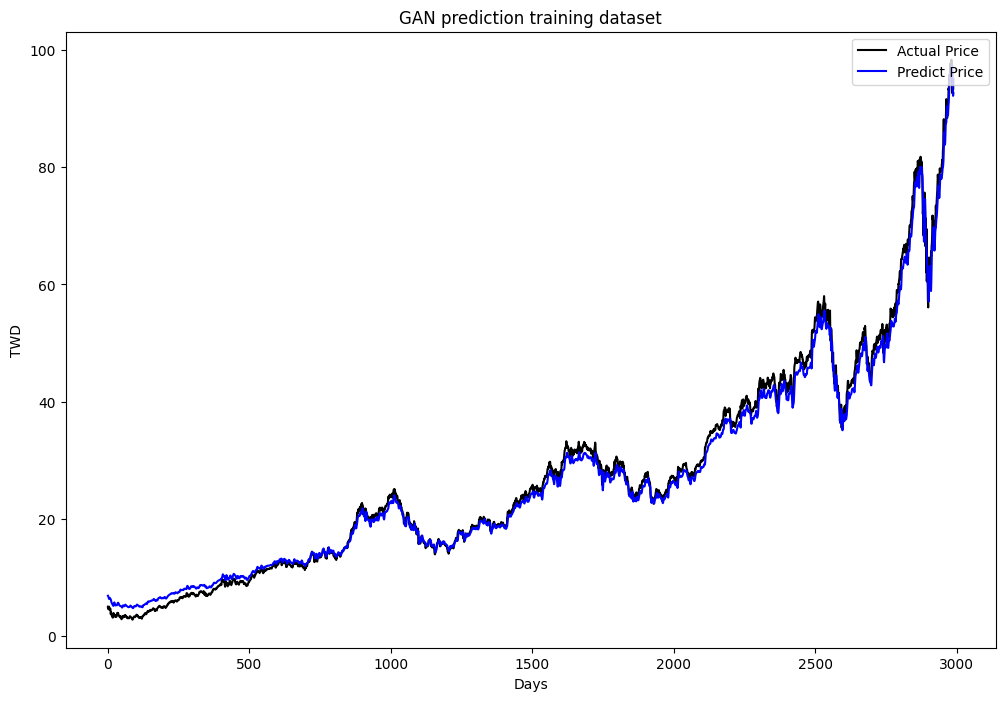

In [52]:

plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Actual Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

RMSE = mean_squared_error(y_train_true, y_train_pred, squared=False)
print(f'Training dataset RMSE:{RMSE}')

Test dataset RMSE:10.758294215871336


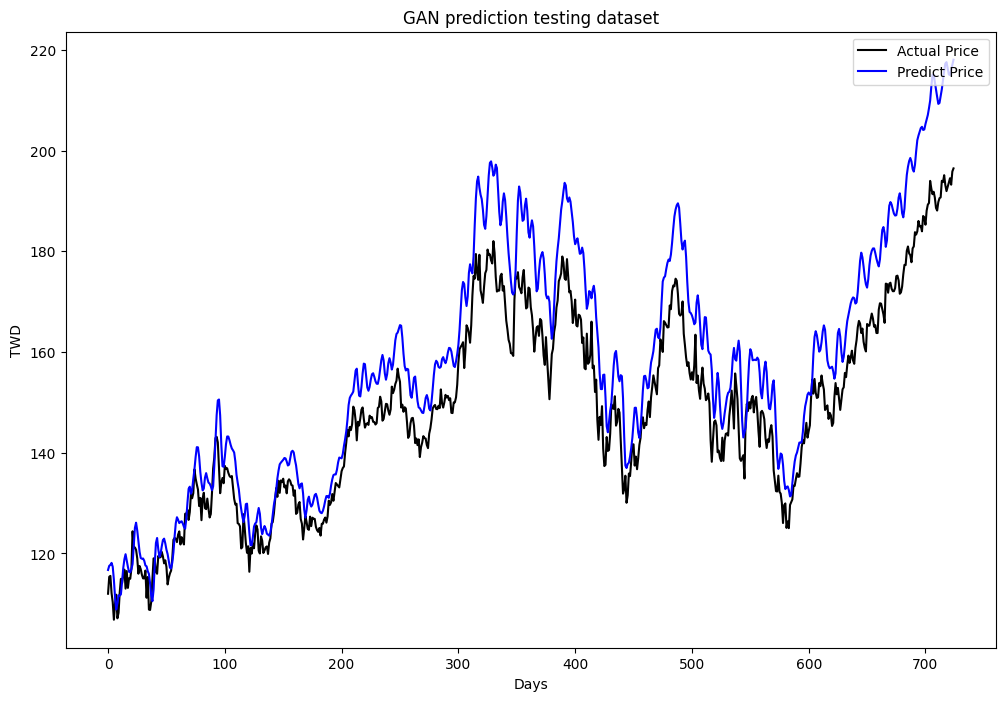

In [53]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Actual Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

RMSE = mean_squared_error(y_test_true, y_test_pred, squared=False)
print(f'Test dataset RMSE:{RMSE}')